In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts.models import NaiveSeasonal
from darts import TimeSeries
from darts.metrics import mape, mae, rmse
from datetime import timedelta

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 22})

In [ ]:
def print_evaluation_metrics(actual,predicted):
    
    actual_series = TimeSeries.from_series(actual)
    predicted_series = TimeSeries.from_series(predicted)

    # Compute MAPE, RMSE and MAE
    mape_val = mape(actual_series, predicted_series)
    rmse_val = rmse(actual_series, predicted_series)
    mae_val = mae(actual_series, predicted_series)

    print(f"MAPE: {mape_val:.2f}%")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE: {mae_val:.2f}MW")

    # Combine into one DataFrame
    df = pd.DataFrame({'actual': actual, 'predicted': predicted})
    df.index = pd.to_datetime(df.index)  # Ensure datetime index

    # Remove rows where actual == 0 to avoid division by zero
    df = df[df['actual'] != 0]

    # Add 'date' column for grouping
    df['date'] = df.index.date

    # Calculate absolute percentage error per row
    df['abs_pct_error'] = np.abs(df['actual'] - df['predicted']) / df['actual']

    # Group by date and calculate daily MAPE
    daily_mape = df.groupby('date')['abs_pct_error'].mean() * 100  # Convert to %

    max_mape_value = daily_mape.max()
    min_mape_value = daily_mape.min()
    max_mape_date = daily_mape.idxmax()
    min_mape_date = daily_mape.idxmin()

    print(f"Maximum MAPE: {max_mape_value:.2f}% on {max_mape_date}")
    print(f"Minimum MAPE: {min_mape_value:.2f}% on {min_mape_date}")
    
def plot_forecast(actual, predicted, model_name,):
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual', linewidth=2)
    plt.plot(predicted.index, predicted, label='Predicted')#linestyle='--'
    #plt.xticks(rotation=45)
    plt.legend()
    plt.title('Load Forecast: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(model_name, format="pdf", bbox_inches="tight")
    plt.show()

In [ ]:
def read_load_data():
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={"Actual Total Load [MW] - BZN|SE4": "Actual Load",
                              "Time (UTC)": "Time"}, 
                              inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

# NSM

MAPE: 8.39%
RMSE: 296.98
MAE: 206.07MW
Maximum MAPE: 42.34% on 2024-11-26
Minimum MAPE: 2.54% on 2024-07-01


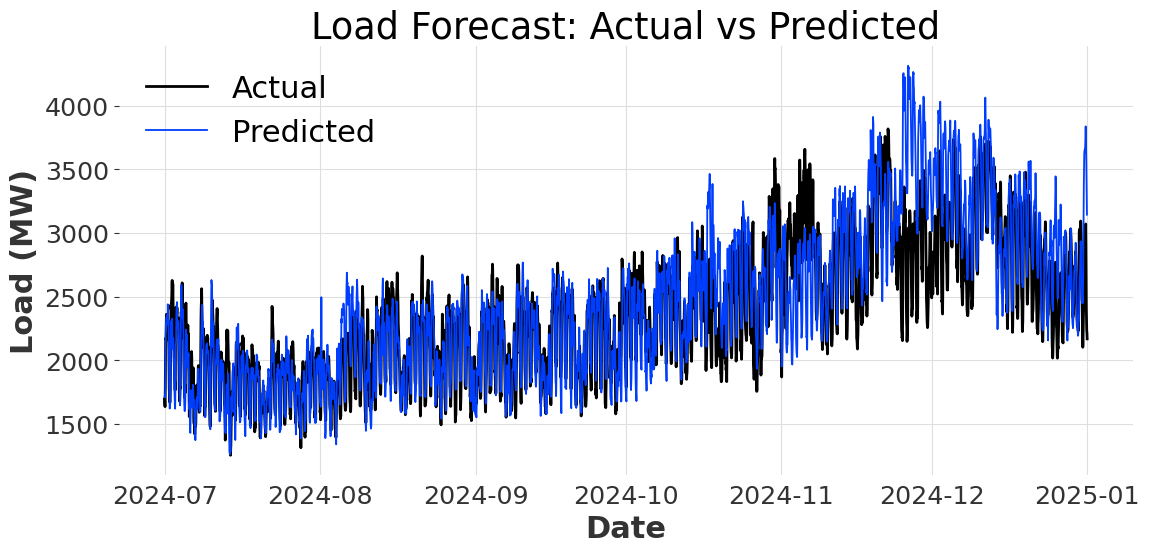

In [8]:
# Load data
forecast_data = data['Actual Load']
series = TimeSeries.from_series(forecast_data)

# Define target forecast length, 2024 leap year -> 366 days
full_hours = 24 * 366  

# Make sure test set ends on final timestamp
test_end = series.end_time()

# Adjust start so that the time window is a multiple of 168 (full weeks)
hours_to_trim = full_hours % 168  # remove excess to get full weeks only
test_start = test_end - timedelta(hours=(full_hours - hours_to_trim) - 1)

# Create actual (test) and training sets
actual = series.slice(test_start, test_end)
train = series.drop_after(test_start - timedelta(hours=1))

# Define NSM model
model = NaiveSeasonal(K=len(actual))
model.fit(train)

# Forecast for the same length as the actual set
forecast = model.predict(len(actual))

# Convert to pandas Series
actual_pd = actual.to_series()
forecast_pd = forecast.to_series()

# Slice to refelct the test set used in this projects
actual_pd = actual_pd['2024-07-01':'2024-12-31']
forecast_pd = forecast_pd['2024-07-01':'2024-12-31']

print_evaluation_metrics(actual_pd,forecast_pd)
plot_forecast(actual_pd,forecast_pd,'NSM')

# ENTSO-E

Evaluation from 2024-07-08 to 2024-12-30
MAPE: 4.86%
RMSE: 162.95
MAE: 117.06MW
Maximum MAPE: 18.36% on 2024-11-02
Minimum MAPE: 1.53% on 2024-11-23


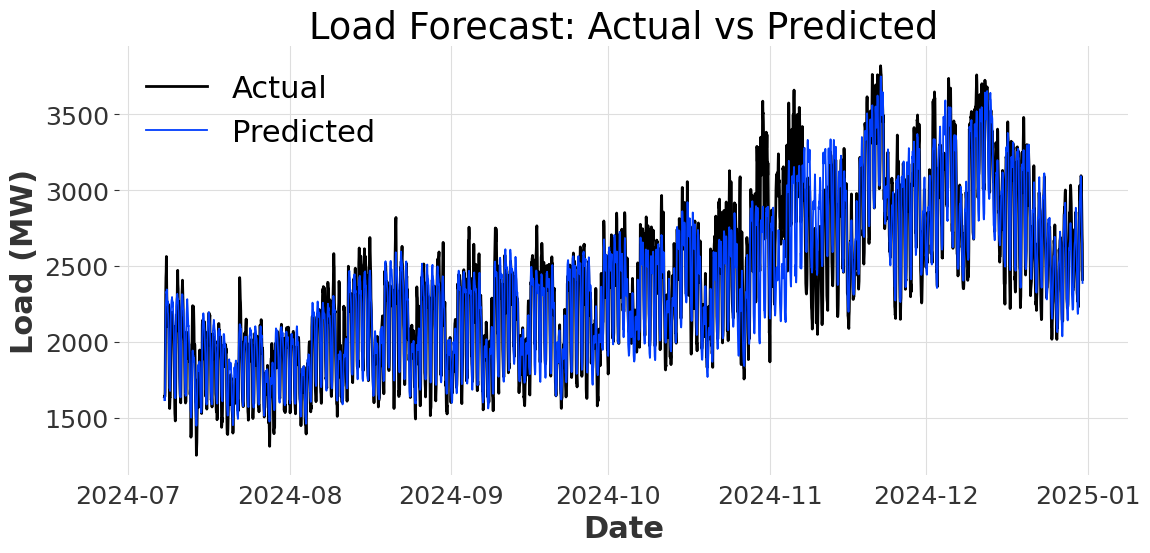

Evaluation from 2024-07-22 to 2024-07-28
MAPE: 3.89%
RMSE: 92.40
MAE: 70.92MW
Maximum MAPE: 6.16% on 2024-07-28
Minimum MAPE: 2.14% on 2024-07-23


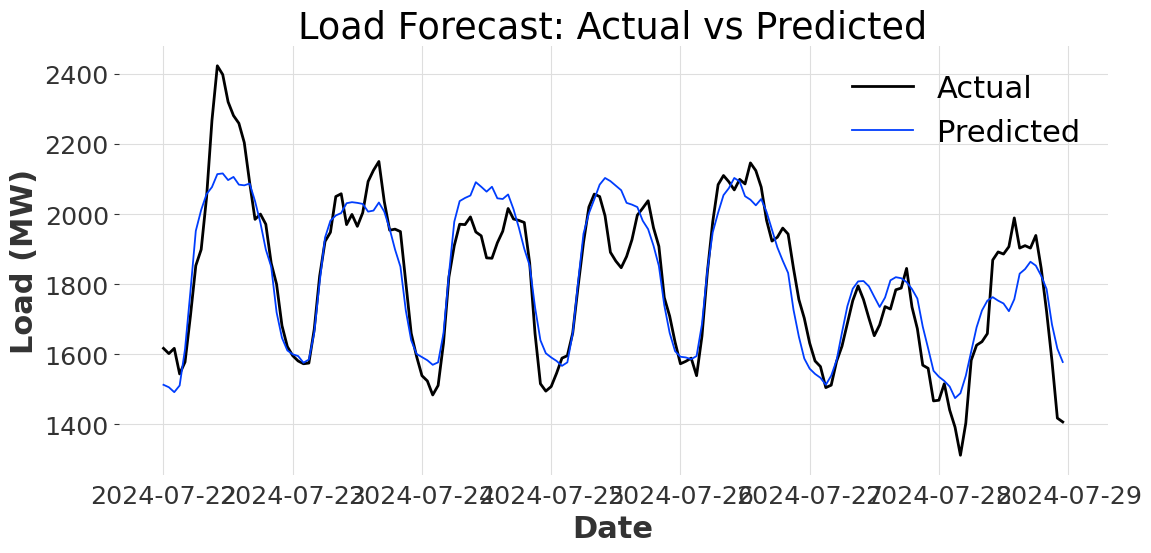

Evaluation from 2024-10-14 to 2024-10-20
MAPE: 4.19%
RMSE: 127.42
MAE: 98.19MW
Maximum MAPE: 6.85% on 2024-10-16
Minimum MAPE: 2.64% on 2024-10-19


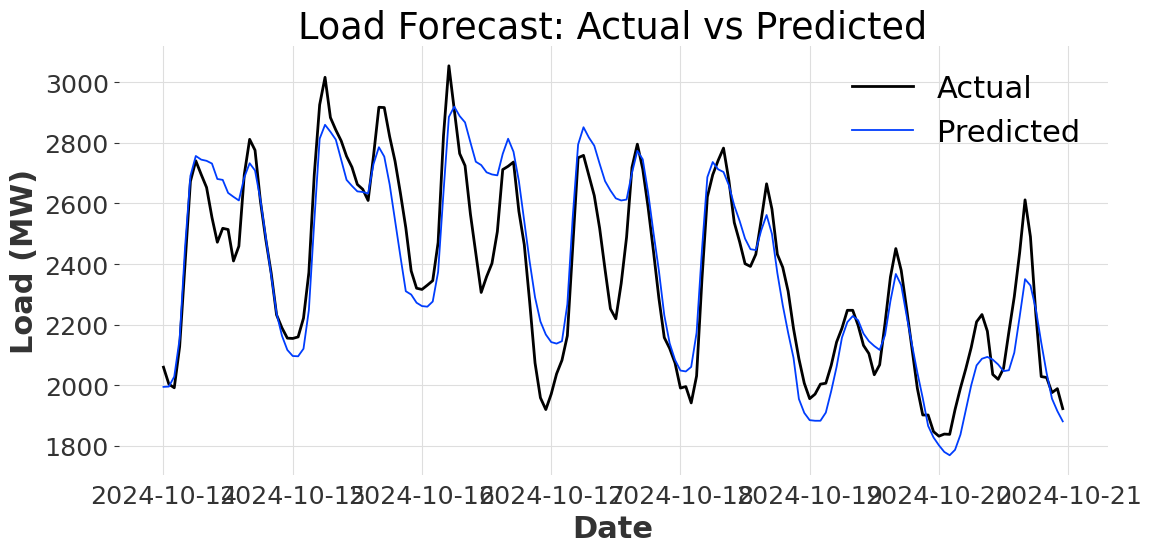

Evaluation from 2024-10-28 to 2024-11-03
MAPE: 12.81%
RMSE: 435.00
MAE: 371.90MW
Maximum MAPE: 18.36% on 2024-11-02
Minimum MAPE: 3.87% on 2024-10-28


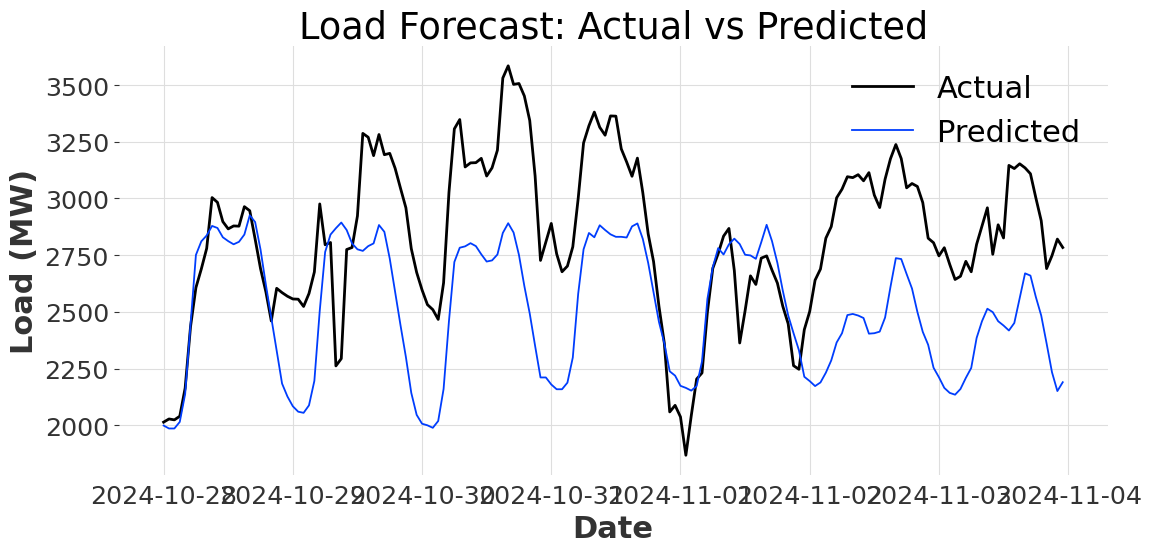

Evaluation from 2024-12-02 to 2024-12-08
MAPE: 3.61%
RMSE: 141.11
MAE: 110.79MW
Maximum MAPE: 6.25% on 2024-12-04
Minimum MAPE: 1.79% on 2024-12-07


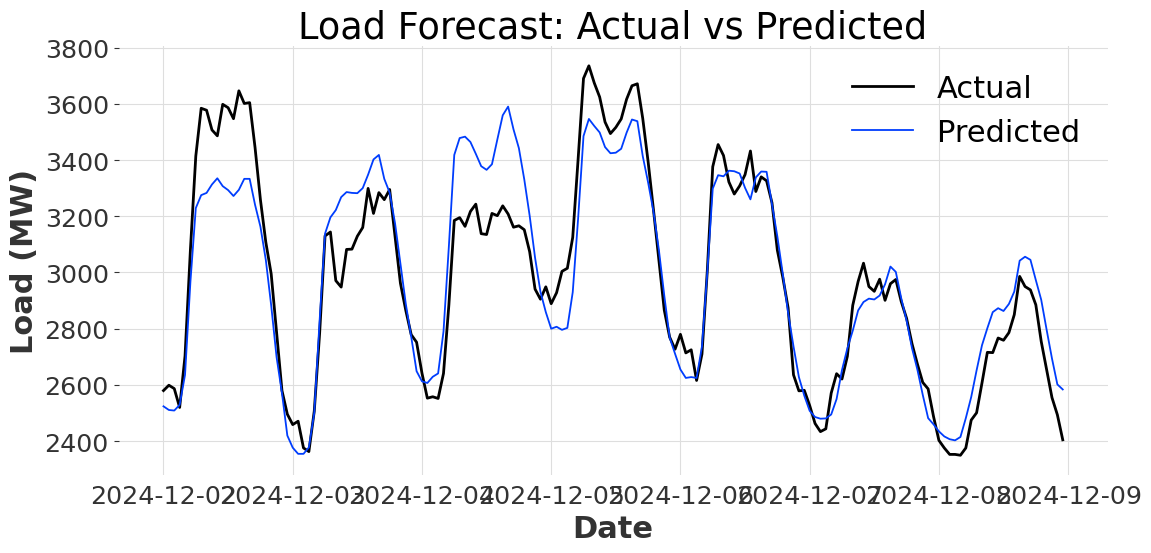

Evaluation from 2024-12-23 to 2024-12-29
MAPE: 3.46%
RMSE: 119.01
MAE: 87.95MW
Maximum MAPE: 6.57% on 2024-12-28
Minimum MAPE: 2.07% on 2024-12-26


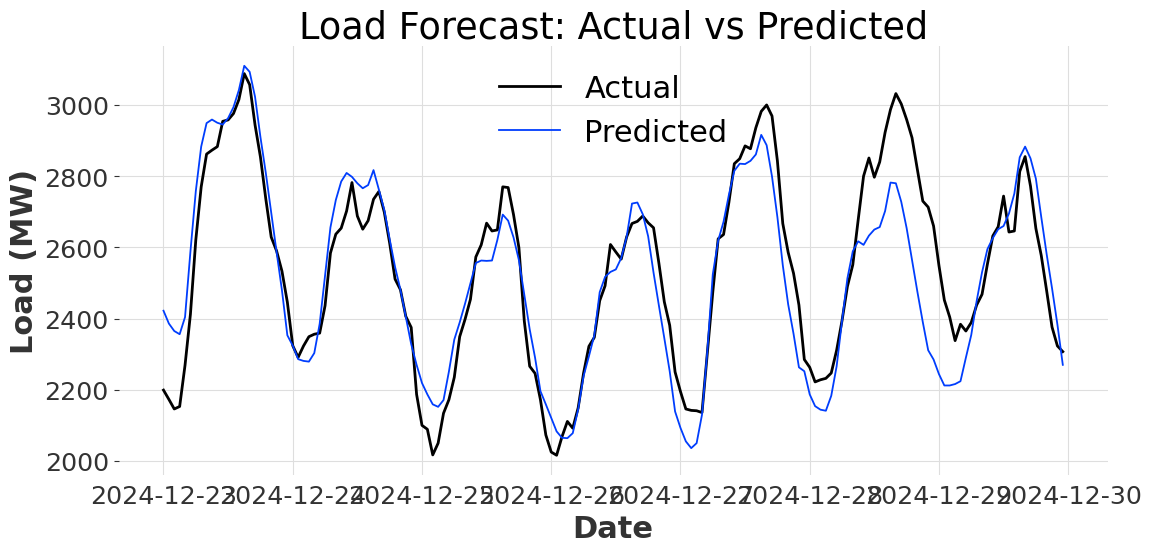

In [9]:
# Load processed load data file, containing actual load and ENTSO-E forecast
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')

entsoe_forecast_vs_actual = pd.read_csv(load_file_path)

entsoe_forecast_vs_actual.rename(columns =
                                 {"Actual Total Load [MW] - BZN|SE4": "Actual Load",
                                  "Day-ahead Total Load Forecast [MW] - BZN|SE4": "Forecast",
                                  "Time (UTC)": "Time"}, 
                                  inplace=True)

entsoe_forecast_vs_actual['Time'] = pd.to_datetime(entsoe_forecast_vs_actual['Time'].str.split(' - ').str[0], 
                                                         format='%d.%m.%Y %H:%M')

entsoe_forecast_vs_actual = entsoe_forecast_vs_actual.set_index('Time')

# Periods to which our forecasts are to be compared to ENTSO-E forecast
eval_periods = [('2024-07-08', '2024-12-30'),
                ('2024-07-22', '2024-07-28'),
                ('2024-10-14', '2024-10-20'),
                ('2024-10-28', '2024-11-03'),
                ('2024-12-02', '2024-12-08'),
                ('2024-12-23', '2024-12-29'),]

# Evaluate all desired time periods
for start_date, end_date in eval_periods:
    print(f"Evaluation from {start_date} to {end_date}")
    
    eval_df = entsoe_forecast_vs_actual[start_date:end_date]
    actual = eval_df["Actual Load"]
    forecast = eval_df["Forecast"]

    print_evaluation_metrics(actual, forecast)
    plot_forecast(actual, forecast,'ENTSO-E')